- Univariate_Time_Series_Forecasting_using_ARIMA

#### Load the Data

In [31]:

!pip install pmdarima


In [32]:

import pandas as pd
import numpy as np
from pmdarima import auto_arima
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [33]:


df = pd.read_csv('/content/IPG2211A2N.csv')


In [34]:



df.head()



,DATE,IPG2211A2N
0,1939-01-01,3.3336
1,1939-02-01,3.3591
2,1939-03-01,3.4354
3,1939-04-01,3.4608
4,1939-05-01,3.4608


In [35]:
df.shape

(1026, 2)

## Data Preprocessing

In [36]:


# checking the null values
df.isna().sum()


,0
DATE,0
IPG2211A2N,0


In [37]:


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        1026 non-null   object 
 1   IPG2211A2N  1026 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.2+ KB


In [38]:


#converting the 'DATE' col dtype to 'datetime'
df['DATE'] = pd.to_datetime(df['DATE'])

In [39]:
# making the 'DATE' col as index
df.set_index('DATE', inplace = True)

In [40]:
df.head()

,IPG2211A2N
DATE,
1939-01-01,3.3336
1939-02-01,3.3591
1939-03-01,3.4354
1939-04-01,3.4608
1939-05-01,3.4608


### 3. Checking the Stationarity of data

<Axes: xlabel='DATE'>

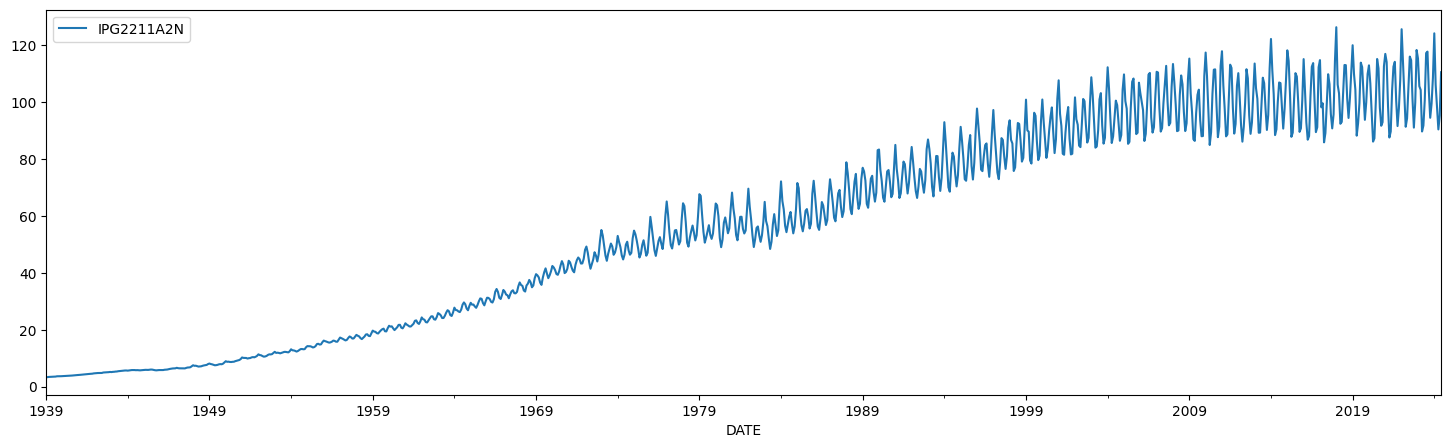

In [41]:
df.plot(figsize=(18, 5))

### **ADF Test**

In [42]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test function
def adf_test(data):
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]}')  # ADF test statistic
    print(f'p-value: {result[1]}')        # p-value of the test
    print(f'# of lags used: {result[2]}')  # Number of lags used in the test
    print(f'# of observations used: {result[3]}')  # Number of observations used for the test
    print('Critical Values:')
    for key, value in result[4].items():   # Critical values at 1%, 5%, and 10% levels
        print(f'   {key}: {value}')

    # Conclusion
    if result[1] <= 0.05:
        print('Reject the Null Hypothesis - Data is Stationary')
    else:
        print('Accept the Null Hypothesis - Data is not Stationary')


In [43]:
adf_test(df['IPG2211A2N'])

ADF Statistic: -0.6881631132022455
p-value: 0.8497917806318546
# of lags used: 22
# of observations used: 1003
Critical Values:
   1%: -3.436886505235454
   5%: -2.8644259034265493
   10%: -2.568306590825728
Accept the Null Hypothesis - Data is not Stationary


- p-value:
 - The p-value of 0.8477 is much higher than 0.05.
 -  This means that the test fails to reject the null hypothesis, which suggests that the data is not stationary.

In [44]:
#First Order Differnencing
df['First_Order'] = df['IPG2211A2N'].diff()

In [45]:
df.head()

,IPG2211A2N,First_Order
DATE,,
1939-01-01,3.3336,NaN
1939-02-01,3.3591,0.0255
1939-03-01,3.4354,0.0763
1939-04-01,3.4608,0.0254
1939-05-01,3.4608,0.0000


In [46]:

df.dropna(inplace = True)

In [47]:
df.head()

,IPG2211A2N,First_Order
DATE,,
1939-02-01,3.3591,0.0255
1939-03-01,3.4354,0.0763
1939-04-01,3.4608,0.0254
1939-05-01,3.4608,0.0000
1939-06-01,3.5117,0.0509


In [74]:
# Performing ADF test on the original data
adf_test(df['IPG2211A2N'])

ADF Statistic: -0.696408694608994
p-value: 0.8476775751415364
# of lags used: 22
# of observations used: 1002
Critical Values:
   1%: -3.436893045520188
   5%: -2.8644287878535146
   10%: -2.568308127138936
Accept the Null Hypothesis - Data is not Stationary


In [48]:
adf_test(df['First_Order'])

ADF Statistic: -10.330269747104389
p-value: 2.854564945428982e-18
# of lags used: 22
# of observations used: 1002
Critical Values:
   1%: -3.436893045520188
   5%: -2.8644287878535146
   10%: -2.568308127138936
Reject the Null Hypothesis - Data is Stationary


- p-value:
 - The p-value is extremely small (much less than 0.05), which means we reject the null hypothesis.
 - This suggests that the data is now stationary.
 - p-value: 2.9096740286338705e-18

<Axes: xlabel='DATE'>

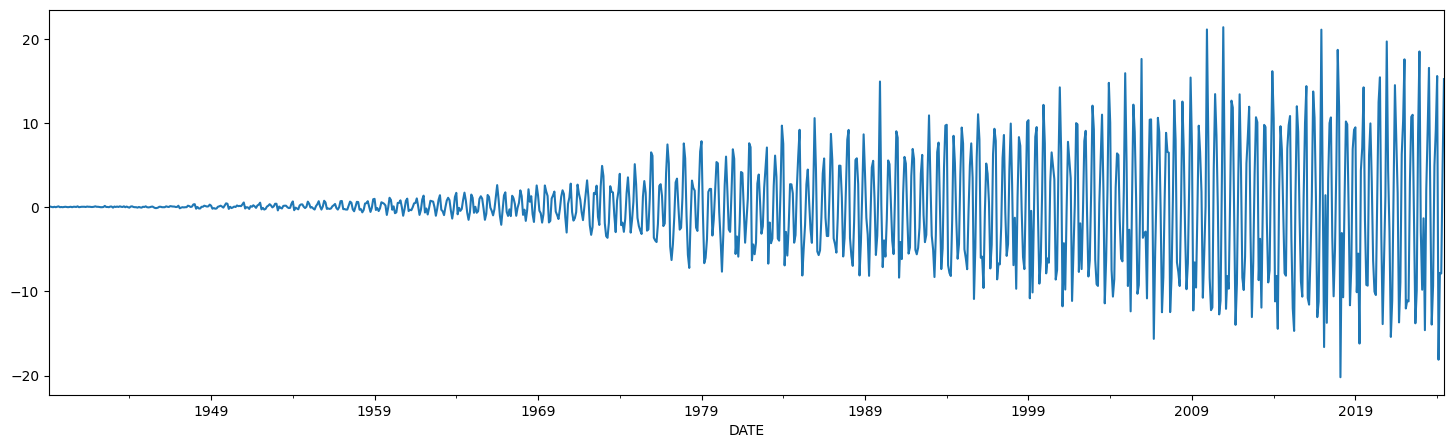

In [75]:
# Plot the differenced data
df['First_Order'].plot(figsize=(18, 5))

### **4. TRain Test Split**

In [53]:
size = int(0.8 * len(df))

In [54]:
size

820

In [55]:
train = df[['First_Order']][:size]
test = df[['First_Order']][size:]

In [56]:
print("Train shape:-",train.shape,"------","Test Shape",test.shape)


Train shape:- (820, 1) ------ Test Shape (205, 1)


In [68]:
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose


### **5. Determine the ARIMA parameters - p,d,q**

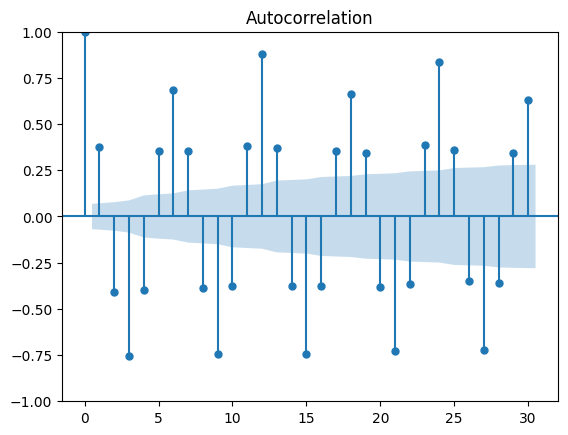

In [57]:
#acf plot - q
acf = plot_acf(train.values)


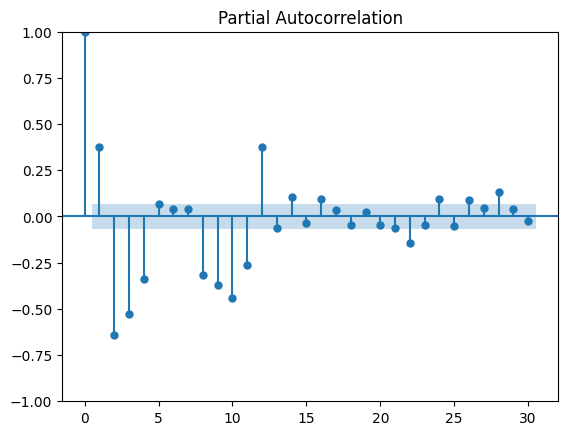

In [58]:
#pacf plot - p
pacf = plot_pacf(train.values)


#### **Selection and Fitting:**

- You determine the ARIMA model parameters (p, d, q) using historical data.
-  In your case, `the auto_arima` function automatically selects the best parameters based on AIC/BIC criteria.

- You then create and fit the ARIMA model using the training dataset. This step involves estimating the model coefficients based on the provided time series data.



In [59]:
# Using auto_arima to determine the best parameters
autoArima = auto_arima(train, seasonal=False)

In [60]:
print(autoArima.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  820
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1752.422
Date:                Fri, 04 Oct 2024   AIC                           3514.843
Time:                        05:07:21   BIC                           3538.390
Sample:                    02-01-1939   HQIC                          3523.878
                         - 05-01-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.001    933.917      0.000       0.998       1.002
ar.L2         -0.9996      0.001  -1586.927      0.000      -1.001      -0.998
ma.L1         -1.0342      0.009   -112.700      0.0

### **6. Building the ARIMA model**

In [61]:

model = ARIMA(train, order = autoArima.order)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### **7.Forecasting the Data**

- After fitting the model,
- you can make predictions for future time steps using the predict method or the forecast method from the fitted model.

- In your case, you used the `auto_arima` model to generate forecasts for the number of periods in the test dataset.
- Here,
 - `n_periods=len(test)`
 - indicates that you want to predict values for the same number of periods as in the test dataset.


- Storing Predictions:

 - The predicted values are then added to the original DataFrame for comparison with actual values.
 - This allows you to visualize and evaluate the performance of your model.
 - # Adding the forecast to the DataFrame
`df['forecast'] = [None] * len(train) + list(forecast)`


In [77]:
##training test we have plot
#we gievn the n_perods
# Forecasting the test period
forecast = autoArima.predict(n_periods=len(test))


# Adding the forecast to the DataFrame
df['forecast'] = [None] * len(train) + list(forecast)



In [79]:
len(test)

205

In [80]:
df['forecast'].shape

(1025,)

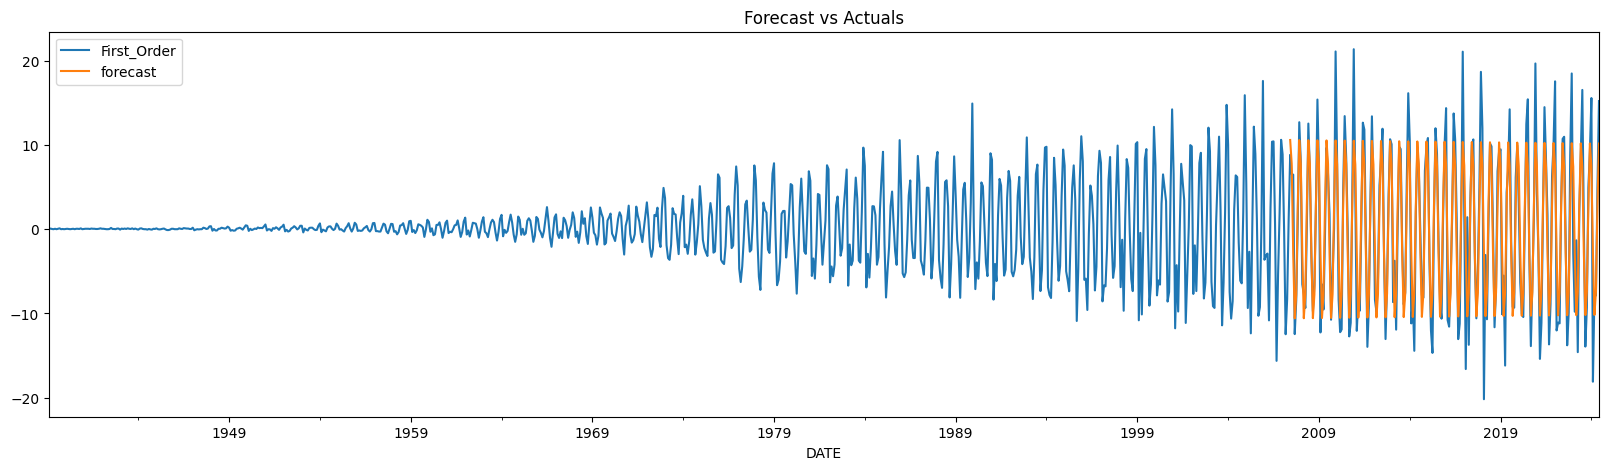

In [78]:
# Plotting the forecast vs actual values
df[['First_Order', 'forecast']].plot(figsize=(20, 5))
plt.title('Forecast vs Actuals')
plt.show()


In [73]:
df.head(820)

,IPG2211A2N,First_Order,forecast
DATE,,,
1939-02-01,3.3591,0.0255,NaN
1939-03-01,3.4354,0.0763,NaN
1939-04-01,3.4608,0.0254,NaN
1939-05-01,3.4608,0.0000,NaN
1939-06-01,3.5117,0.0509,NaN
...,...,...,...
2007-01-01,110.7058,8.8848,NaN
2007-02-01,110.4540,-0.2518,NaN
2007-03-01,97.9823,-12.4717,NaN


In [72]:
df.tail(205)

,IPG2211A2N,First_Order,forecast
DATE,,,
2007-06-01,99.7503,8.8296,10.591273
2007-07-01,106.3227,6.5724,7.771779
2007-08-01,112.7922,6.4695,-2.817194
2007-09-01,100.3374,-12.4548,-10.585028
2007-10-01,91.8884,-8.4490,-7.766190
...,...,...,...
2024-02-01,106.1255,-18.1070,-2.773362
2024-03-01,98.3226,-7.8029,-10.180689
2024-04-01,90.4537,-7.8689,-7.405772


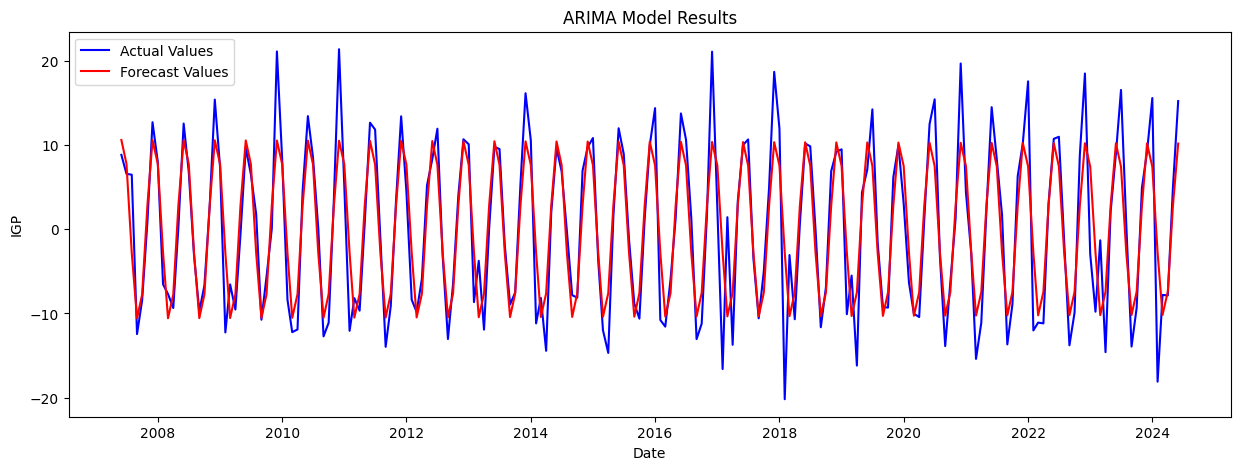

In [82]:


#plotting the test results

plt.figure(figsize = (15, 5))
plt.plot(df['First_Order'][820:], color = 'blue', label = 'Actual Values')
plt.plot(df['forecast'][820:], color = 'red', label = 'Forecast Values')
plt.title('ARIMA Model Results')
plt.xlabel('Date')
plt.ylabel('IGP')
plt.legend()

### **Evaluation:**

- Finally, to quantify how well the model performed, you calculate evaluation metrics such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).
- These metrics help determine the accuracy of the predictions by comparing the forecasted values against the actual observed values.

In [66]:

#evaluating metrics
mae = mean_absolute_error(df['First_Order'][820:], df['forecast'][820:])
rmse = np.sqrt(mean_squared_error(df['First_Order'][820:], df['forecast'][820:]))

print(f'Mean Absolute Error (MAE) : {mae}')
print(f'Root Mean Square Error (RMSE) : {rmse}')


Mean Absolute Error (MAE) : 3.287935428547524
Root Mean Square Error (RMSE) : 4.487485022677574
